In [33]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from tqdm import tqdm

In [34]:
# hyperparameters
batch_size = 8
block_size = 256
max_iters = 5000
eval_interval = 500
learning_rate = 3e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 50
n_embd = 768
n_head = 64 # D = 384 // 6
n_layer = 12
dropout = 0.2
# ------------

torch.manual_seed(1337)

In [35]:
with open("/kaggle/input/wiki-with-dot-coma-txt/dataset_with_dot_and_coma.txt", "r") as f:
    text = f.read()

In [36]:
chars = sorted(list(set(text)))
vocab_size = len(chars)
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s]
decode = lambda l: ''.join([itos[i] for i in l])

In [37]:
len(text) 

213387588

In [38]:
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9 * len(data))
train_data = data[:n]
val_data = data[n:]

def get_batch(split):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

In [39]:
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

In [40]:
class MultiHeadAttention_Parallel(nn.Module):

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size * num_heads, bias = False)
        self.query = nn.Linear(n_embd, head_size * num_heads, bias = False)
        self.value = nn.Linear(n_embd, head_size * num_heads, bias = False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)
        self.num_heads = num_heads
        self.head_size = head_size

        self.proj = nn.Linear(head_size * num_heads, n_embd)

    def forward(self, x):
        # input of size (B, T, C)
        # output of size (B, T, D * num_heads)

        B, T, C = x.shape
        k = self.key(x).reshape(B, T, self.num_heads, self.head_size).transpose(1, 2) # (B, head_size, T, num_heads)
        q = self.query(x).reshape(B, T, self.num_heads, self.head_size).transpose(1, 2) # (B, head_size, T, num_heads)
        v = self.value(x).reshape(B, T, self.num_heads, self.head_size).transpose(1, 2) # (B, head_size, T, num_heads)

        masks = self.tril[:T, :T].unsqueeze(0).unsqueeze(0)
        wei = q @ k.transpose(-2, -1) * k.shape[-1] ** -0.5
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        wei = F.softmax(wei, dim =- 1)
        wei = self.dropout(wei)
        out = wei @ v

        out = out.transpose(1, 2).contiguous().view(B, T, self.head_size * self.num_heads)
        out = self.dropout(self.proj(out))

        return out

In [41]:
class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)


In [42]:
class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention_Parallel(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

In [43]:
class GPTLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size)

        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -block_size:]
            logits, loss = self(idx_cond)
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx

In [44]:
model = GPTLanguageModel()
m = model.to(device)
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

85.311032 M parameters


In [45]:
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

In [46]:
try:
    train_losses = []
    val_losses = []
    
    for iter in tqdm(range(max_iters)):
        if iter % eval_interval == 0 or iter == max_iters - 1:
            losses = estimate_loss()

            t_loss = losses['train']
            v_loss = losses['val']
        
            val_losses.append(v_loss)
        
            print(f"step {iter}: train loss {t_loss:.4f}, val loss {v_loss:.4f}")


        xb, yb = get_batch('train')
        logits, loss = model(xb, yb)
        optimizer.zero_grad(set_to_none=True)
        train_losses.append(loss)
        loss.backward()
        optimizer.step()

except KeyboardInterrupt: 0

  0%|          | 1/5000 [00:09<13:06:10,  9.44s/it]

step 0: train loss 4.0434, val loss 4.0417


 10%|█         | 501/5000 [02:48<3:54:29,  3.13s/it]

step 500: train loss 2.5394, val loss 2.5478


 20%|██        | 1001/5000 [05:27<3:28:57,  3.14s/it]

step 1000: train loss 2.4861, val loss 2.4941


 30%|███       | 1501/5000 [08:07<3:04:23,  3.16s/it]

step 1500: train loss 2.2617, val loss 2.2547


 40%|████      | 2001/5000 [10:47<2:38:47,  3.18s/it]

step 2000: train loss 2.0712, val loss 2.0870


 50%|█████     | 2501/5000 [13:27<2:12:14,  3.17s/it]

step 2500: train loss 1.9575, val loss 1.9662


 60%|██████    | 3001/5000 [16:07<1:45:40,  3.17s/it]

step 3000: train loss 1.8445, val loss 1.8722


 70%|███████   | 3501/5000 [18:46<1:19:06,  3.17s/it]

step 3500: train loss 1.7921, val loss 1.7687


 80%|████████  | 4001/5000 [21:26<52:30,  3.15s/it]  

step 4000: train loss 1.6993, val loss 1.7198


 90%|█████████ | 4501/5000 [24:05<26:10,  3.15s/it]

step 4500: train loss 1.6678, val loss 1.6474


100%|██████████| 5000/5000 [26:45<00:00,  3.12it/s]

step 4999: train loss 1.6287, val loss 1.6212


In [47]:
prompt = "Soviet Union"
context = torch.tensor([encode(prompt)], dtype=torch.int32, device=device)
print(decode(m.generate(context, max_new_tokens = 500)[0].tolist()))

Soviet Union. The made also a tember helping size Didle Churcreas Britains Ny Moster. Lister Lind Mininin when she name Europe were to the sarviving was to in New was the prequence in  South object as as and the meditial hable neaternated story become of the is intern on the motal landesign into attriography oxilem.
Lover Ovenn her espell staid Vectorient It. In , Manultine happerble the history in Acudied at the that cell in the condicities diplace. Unted Senastitutions relied Cander with exitiventting wit


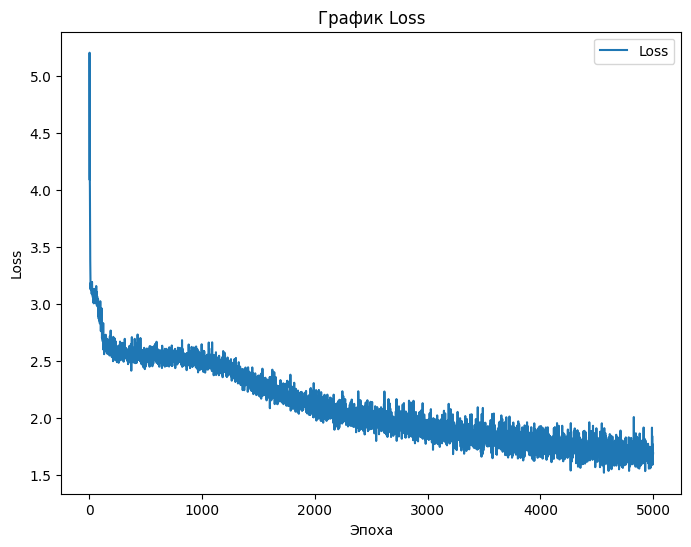

In [48]:
loss_train = [el.detach().cpu() for el in train_losses]
# loss_train = [el.item() for el in val_losses]

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(loss_train, label='Loss')

ax.set_title('График Loss')
ax.set_xlabel('Эпоха')
ax.set_ylabel('Loss')
ax.legend()

plt.show()

In [49]:
torch.save(model, "gpt2_85m_clean_all_symbs.pth")